# Analyse de la croissance de capacité solaire en France

La croissance de la capacité solaire en France doit être prise en compte de manière à normaliser la production solaire dans notre modèle.

### Import des libraries

In [1]:
import pandas as pd
import scipy 
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Dict
import os
import logging
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Confirmation d'être à la racine du dossier
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(project_root)

### Filtrage des données solaire et sur la région Occitanie

In [3]:
df = pd.read_csv("data/external/registre-national-installation-production-stockage-electricite-agrege.csv", sep=";", low_memory=False)
df.head()

,idPEPS,nomInstallation,codeEICResourceObject,codeIRIS,codeINSEECommune,commune,codeEPCI,EPCI,codeDepartement,departement,...,productible,debitMaximal,codeGestionnaire,gestionnaire,energieAnnuelleGlissanteInjectee,energieAnnuelleGlissanteProduite,energieAnnuelleGlissanteSoutiree,energieAnnuelleGlissanteStockee,maxPuis,dateMiseEnservice (format date)
0,23X160203-000021-222235COR1,Confidentiel,17W0000015765488,2A0010000,2A001,Afa,242010056,CA du Pays Ajaccien,2A,Corse-du-Sud,...,NaN,NaN,23X160203-000021,EDF-SEI,NaN,NaN,NaN,NaN,74.7,2023-05-17
1,23X160203-000021-222303COR1,Confidentiel,17W000002169863B,2A0010000,2A001,Afa,242010056,CA du Pays Ajaccien,2A,Corse-du-Sud,...,NaN,NaN,23X160203-000021,EDF-SEI,NaN,NaN,NaN,NaN,100.0,2024-04-16
2,23X160203-000021-257171272COR1,Confidentiel,17W0000013300061,2A0010000,2A001,Afa,242010056,CA du Pays Ajaccien,2A,Corse-du-Sud,...,NaN,NaN,23X160203-000021,EDF-SEI,NaN,NaN,NaN,NaN,99.9,2019-05-28
3,23X160203-000021-222315COR1,Confidentiel,17W0000021698649,2A0010000,2A001,Afa,242010056,CA du Pays Ajaccien,2A,Corse-du-Sud,...,NaN,NaN,23X160203-000021,EDF-SEI,NaN,NaN,NaN,NaN,100.0,2024-05-22
4,23X160203-000021-COR3161791,Confidentiel,17W000002229049H,2A0010000,2A001,Afa,242010056,CA du Pays Ajaccien,2A,Corse-du-Sud,...,NaN,NaN,23X160203-000021,EDF-SEI,0.0,NaN,0.0,NaN,99.9,2019-07-16


In [4]:
def solar_puissance_filter(df_installed_puissance: pd.DataFrame, region_code: int) -> pd.DataFrame: 
    """Retourne le dataset de la puissance solaire installée (après appel api) sur la région de code region_code.

    Args:
        df_installed_puissance (pd.DataFrame): Dataset issu du registre des infrastructures de production d'énergie (API data.gouv)
        region_code (int): Code INSEE de la région

    Returns:
        df_solar_puissance (pd.DataFrame) : Dataset puissance solaire installée sur la région code_region
    """
    # Solar filter
    reg_capacity = df_installed_puissance.groupby(["codeRegion", "dateMiseEnService", "filiere"])["puisMaxInstallee"].sum()
    reg_capacity = reg_capacity.reset_index()
    df_solar_puissance = reg_capacity[reg_capacity["filiere"]=="Solaire"].drop(columns="filiere")
    
    # Spatial filter
    df_solar_puissance = df_solar_puissance[df_solar_puissance["codeRegion"] == region_code]

    # Time conversion
    df_solar_puissance.loc[:, "dateMiseEnService"] = pd.to_datetime(df_solar_puissance["dateMiseEnService"], format="%d/%m/%Y")

    return df_solar_puissance

In [5]:
reg_capacity_occ = solar_puissance_filter(df, 76)
reg_capacity_occ.head()

,codeRegion,dateMiseEnService,puisMaxInstallee
28345,76.0,1900-01-01 00:00:00,936.32
28358,76.0,2006-01-01 00:00:00,281.17
28360,76.0,2007-01-01 00:00:00,860.24
28365,76.0,2014-01-01 00:00:00,279.99
28370,76.0,2016-01-01 00:00:00,529.77


### Analyse de la mise en services des infrastructures de production solaire

Analysons maintenant les outliers temporels que nous pourrions retrouver dans le dataframe.

<Axes: xlabel='dateMiseEnService', ylabel='Count'>

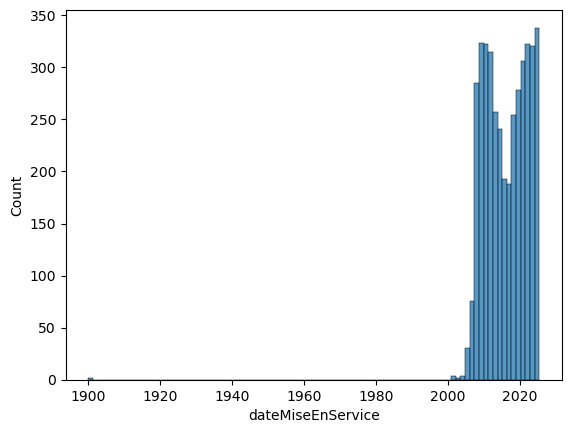

In [6]:
sns.histplot(reg_capacity_occ["dateMiseEnService"])

Des outliers temporels sont au nombre de 2 et représentent 1,3MW, soit 0.03% du total des infrastructures recensées dans ce tableau. Nous pouvons donc négliger ces 2 outliers; mais conserver un test simple au regard de la masse de puissance qu'ils représentent.

In [7]:
def delete_temporal_outlier(df_solar_puissance: pd.DataFrame) -> pd.DataFrame:
    """Supprime les outliers temporels basés sur une date de mise en service anormalement ancienne.

    Args:
        df_solar_puissance (pd.DataFrame): DataFrame contenant les données de production solaire, 
        avec une colonne 'dateMiseEnService' et 'puisMaxInstallee'.

    Returns:
        pd.DataFrame: DataFrame nettoyé sans les outliers temporels, sauf s'ils sont significatifs.
    """
    # Filtrage des outliers temporels
    filter = (df_solar_puissance["dateMiseEnService"] < pd.Timestamp("1990-01-01"))
    ancient_solar_production = df_solar_puissance[filter]
    df_puiss = df_solar_puissance[~filter]

    # Total des puissances outliers et correctes
    total_puiss = df_puiss["puisMaxInstallee"].sum()
    outlier_puiss = ancient_solar_production["puisMaxInstallee"].sum()
    pourcentage_outliers = outlier_puiss / total_puiss * 100
    

    if pourcentage_outliers >= 0.01:
        
        df_solar_puissance.loc[filter, "dateMiseEnService"] = df_puiss["dateMiseEnService"].iloc[0]
        logging.info(f"{pourcentage_outliers:.2f}% du total détectés comme outliers temporels -> outliers conservés et initialisés à la première date du dataframe de départ")
        
        return df_solar_puissance
    
    else:
        logging.info(f"{pourcentage_outliers:.2f}% du total détectés comme outliers temporels -> outliers supprimés car négligeables")

    return df_puiss


In [8]:
df_solar_puissance = delete_temporal_outlier(reg_capacity_occ)
df_solar_puissance.head()

,codeRegion,dateMiseEnService,puisMaxInstallee
28345,76.0,2006-01-01 00:00:00,936.32
28358,76.0,2006-01-01 00:00:00,281.17
28360,76.0,2007-01-01 00:00:00,860.24
28365,76.0,2014-01-01 00:00:00,279.99
28370,76.0,2016-01-01 00:00:00,529.77


Nous considérerons que le registre des infrastructures de production d'énergie maintenu par la gouvernement ne contient pas de valeurs aberrantes concernant leur puissance maximale.

### Courbe cumulée de la capacité dans la région Occitanie

Traçons maintenant la courbe cumulée de la puissance maximale mise en service en région Occitanie.

In [9]:
reg_capacity_occ = reg_capacity_occ.sort_values(by="dateMiseEnService")
occ_capacity = reg_capacity_occ.set_index("dateMiseEnService")
reg_capacity_occ.describe()

,codeRegion,puisMaxInstallee
count,4060.0,4060.000000
mean,76.0,1184.945603
std,0.0,2126.584150
min,76.0,0.000000
25%,76.0,233.942500
50%,76.0,547.415000
75%,76.0,1217.000000
max,76.0,36883.840000


In [10]:
occ_capacity["puisinstallee_chronique"] = occ_capacity["puisMaxInstallee"].cumsum()

<Axes: xlabel='dateMiseEnService', ylabel='puisinstallee_chronique'>

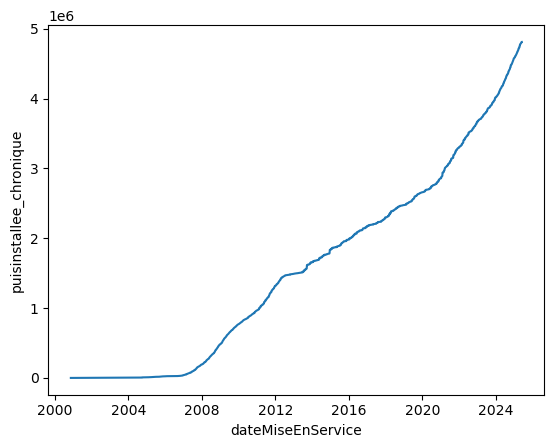

In [11]:
sns.lineplot(occ_capacity["puisinstallee_chronique"])

Nous pouvons remarquer que un point d'inflexion très important en 2008 de la puissance solaire installée en Occitanie. Cela est dû, d'une part à la recrudescence de nombreux projets d'installations solaires dans la région Midi-Pyrénées (anciennement), d'autre part à une simplification des processus administratifs, par une première note de cadrage validée le 23/07/2009 (Doctrine régionale, animé par la DREAL Division Energie Occitanie).

### Capacité sur l'intervalle d'étude 2023 - 2025 

Prenons maintenant l'intervalle d'étude de la production solaire utilisée comme dataset d'entrainement, de validation et de test. Nous utiliserons la puissance maximale mise en service pour normaliser la puissance observée (trend croissante au fil des années).

In [12]:
def cumulative_solar_puissance(df_solar_puissance: pd.DataFrame, start_date: str, end_date: str, resample_method: str = 'W'):
    """Retourne l'intervalle pertinent df_total_capacity considéré dans l'appel d'api de la production solaire RTE.

    Args:
        df_solar_puissance (pd.DataFrame): Dataset filtré des infrastructures de production solaire
        start_date (str): date initiale de l'intervalle 
        end_date (str): date finale de l'intervalle
        resample_method (str, optional): Argument donnant l'agrégation temporelle (W pour week, H pour heure...). Defaults to 'W'.

    Returns:
        df_total_capacity (pd.DataFrame) : Dataset filtré sur l'intervalle (start_date, end_date), munie de la courbe cumulée de puissance associée.
    """
    # Separation de la droite et de la gauche
    df_capacity_r = df_solar_puissance[df_solar_puissance["dateMiseEnService"] >= pd.Timestamp(start_date)]
    df_capacity_r = df_capacity_r.set_index('dateMiseEnService')
    df_capacity_l = df_solar_puissance[df_solar_puissance["dateMiseEnService"] < pd.Timestamp(start_date)]
   
    # Calcul de la baseline
    baseline_capacity = df_capacity_l["puisMaxInstallee"].sum()

    # Initialisation de la somme cumulée
    df_capacity_r.loc[:, "chronique_capacity"] = df_capacity_r["puisMaxInstallee"].cumsum()
    df_capacity_r.loc[:, "chronique_capacity"] += baseline_capacity

    # Resample (optionnel)
    df_total_capacity = df_capacity_r["chronique_capacity"].resample(resample_method).transform('mean')/1E3 #MW

    # On filtre sur la fin
    df_total_capacity = df_total_capacity[df_total_capacity.index < pd.Timestamp(end_date)]
    logging.info(f"DataFrame puissance cumulée sur l'intervalle [{start_date}, {end_date}] créé")

    return df_total_capacity

In [15]:
start_date = '2023-01-01'
end_date = '2025-06-01'
df_total_capacity = cumulative_solar_puissance(reg_capacity_occ, start_date, end_date)
df_total_capacity.tail()

dateMiseEnService
2025-05-23    4800.537347
2025-05-26    4809.291037
2025-05-27    4809.291037
2025-05-28    4809.291037
2025-05-30    4809.291037
Name: chronique_capacity, dtype: float64

Text(0, 0.5, 'Puissance installée (MW)')

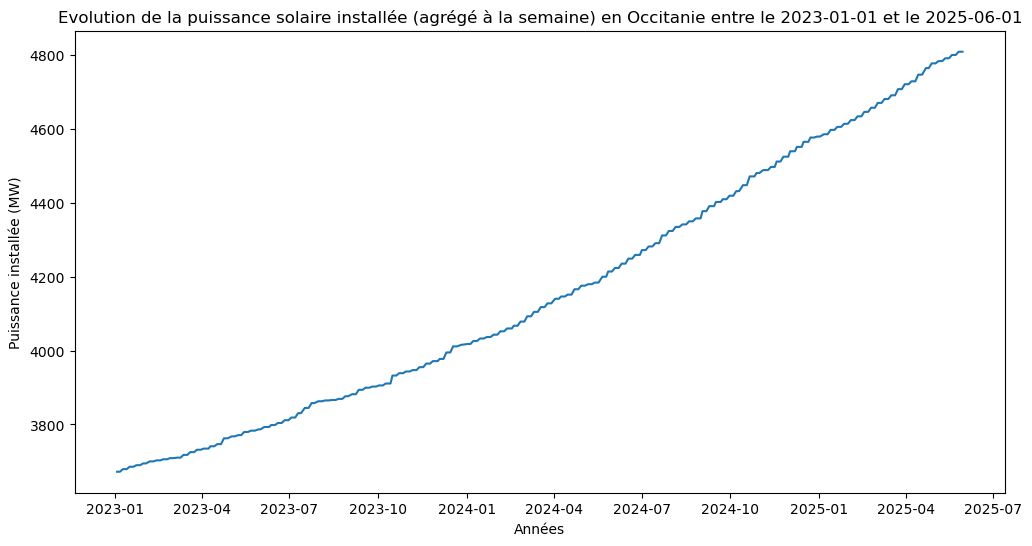

In [ ]:
fig = plt.figure(figsize=(12, 6))
sns.lineplot(df_total_capacity)
plt.title(f"Evolution de la puissance solaire installée (agrégée à la semaine) en Occitanie entre le {start_date} et le {end_date}")
plt.xlabel("Années")
plt.ylabel("Puissance installée (MW)")